# Tesseract with rotation and NMS

In [1]:
from pytesseract import Output
import pytesseract
import numpy as np 
import cv2
import os
import matplotlib.pyplot as plt
import copy
from nms import nms
import math
from typing import Dict, List


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [50]:
image_path = "testfiles"
output_path = "outputs"
text_output_folder = "extracted_text"
visual_result_path = "visualizations"
os.makedirs(output_path, exist_ok=True)
os.makedirs(text_output_folder, exist_ok=True)
os.makedirs(visual_result_path, exist_ok=True)
img_idx = -30
denoising = True
thresholding = True
resize_factor = 2

In [3]:
filenames = os.listdir(image_path)
filename = f'{image_path}/{filenames[img_idx]}'

In [54]:
class OCRModel():

    def __init__(self, confidence_threshold : int = 80, img_rotation_angle_range : range = range(-45,45,5)):

        self.confidence_threshold = confidence_threshold
        self.img_rotation_angle_range = img_rotation_angle_range
    
    @staticmethod
    def load_and_process_image(img_path : str, apply_denoising : bool = True, apply_thresholding : bool = True, img_resize_factor : int = 2, save_result_path : str = None) -> np.ndarray:

        try:
            img = cv2.imread(img_path)
        except: 
            raise("Could not read image")
            
        img = cv2.resize(img, (img.shape[1]*img_resize_factor, img.shape[0]*img_resize_factor))

        if apply_denoising:
            img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)

        dominant_color = np.mean(img)

        # Apply this only for images with dark background (thus low text - background contrast)
        if dominant_color < 100:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
            # Here we are defining range of bluecolor in HSV 
            lower_blue = np.array([110,50,50]) 
            upper_blue = np.array([130,255,255])
            # This creates a mask of blue coloured  
            # objects found in the frame. 
            mask = cv2.inRange(hsv, lower_blue, upper_blue) 
            # The bitwise and of the frame and mask is done so  
            # that only the blue coloured objects are highlighted  
            # and stored in res 
            img = cv2.bitwise_and(img,img, mask= mask) 
            apply_thresholding = True
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # threshold the image using Otsu's thresholding method
        if apply_thresholding:
            img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        if save_result_path:
            plt.figure(figsize=(20,12))
            plt.imsave(save_result_path, img, cmap='gray')
        
        return img
    
    @staticmethod
    def __rotate(origin, point, angle):
        """
        Rotate a point counterclockwise by a given angle around a given origin.

        The angle should be given in radians.
        """
        ox, oy = origin
        px, py = point

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        return qx, qy 
    
    @staticmethod
    def __visualize_results(img_path : str, filtered_rrects : List, filtered_texts : List, save_path : str = None):

        try:
            img = cv2.imread(img_path)
        except: 
            raise("Could not read image")

        for rrect, text in zip(filtered_rrects, filtered_texts): 
            box = cv2.boxPoints(rrect)
            box = np.int0(box)
            cv2.drawContours(img,[box],0,(0,0,255),2)  
            cv2.putText(img, text, (box[0][0], box[0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)

        plt.figure(figsize=(20,12))
        if save_path is None: 
            plt.imshow(img)
        else:
            plt.imsave(save_path, img, cmap='gray')

    @staticmethod
    def __save_results_in_txt(txt_path, filtered_rrects : List, filtered_texts : List):

        with open(txt_path, "w") as f:
            for i in range(len(filtered_rrects)):
                f.write(f"Found text: {filtered_texts[i]}; Center position (in pixels): ({filtered_rrects[i][0][0]},{filtered_rrects[i][0][1]}); Dimension (width, height): ({filtered_rrects[i][1][0]},{filtered_rrects[i][1][1]}); Orientation (degrees): {filtered_rrects[i][2]}\n")
    
    def __apply_tesseract(self, image : np.ndarray, angle : int, all_results : Dict[int, Dict[str, List]], img_resize_factor : int):

        # Applying Tesseract to extract text
        results = pytesseract.image_to_data(image, output_type=Output.DICT)

        # Saving the predictions that are over the specified threshold and contain Latin characters
        # The predictions are stored in a dictionary, where the key is the rotation angle. This is necessary in order to eliminate later double detections in different angles
        all_results[angle] = {"left": [], "top": [], "height": [], "width": [], "conf": [], "text": []}

        for i in range(0, len(results["text"])):
            x = results["left"][i]
            y = results["top"][i]

            w = results["width"][i]
            h = results["height"][i]

            text = results["text"][i]
            conf = int(results["conf"][i])

            if conf > self.confidence_threshold:
                text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
                if text != "" and len(text) > 1:
                    all_results[angle]["left"].append(x//img_resize_factor)
                    all_results[angle]["top"].append(y//img_resize_factor)

                    all_results[angle]["width"].append(w//img_resize_factor)
                    all_results[angle]["height"].append(h//img_resize_factor)

                    all_results[angle]["conf"].append(conf)
                    all_results[angle]["text"].append(text)

    def __filter_double_detections(self, unfiltered_results : Dict[int, Dict[str, List]], image_centerX : int, image_centerY : int, img_resize_factor : int):

        rrects = []
        scores = []
        texts = []

        # Calculating the original center point (before eventual upscaling) of the image for rotation
        orig_img_centerX, orig_image_centerY = image_centerX // img_resize_factor, image_centerY // img_resize_factor
        # Transforming back the rotated bounding boxes to the original image
        for angle in self.img_rotation_angle_range:               
            result = unfiltered_results[angle]

            for i in range(0, len(result["text"])):
                x = result["left"][i]
                y = result["top"][i]

                w = result["width"][i]
                h = result["height"][i]

                text = result["text"][i]
                conf = result["conf"][i]

                rect_center_x = (2*x+w)//2
                rect_center_y = (2*y+h)//2
                qx, qy = OCRModel.__rotate((orig_img_centerX, orig_image_centerY),(rect_center_x, rect_center_y), math.radians(angle))
                rrect = ((int(qx),int(qy)), (w,h), angle)
                rrects.append(rrect)
                scores.append(conf)
                texts.append(text)

        # Applying Non-Maximum Suppression to remove double detection potentially caused by processing the image in various angles
        nms_res = nms.rboxes(rrects, scores, nms_algorithm=nms.felzenszwalb.nms)   
        filtered_rrects = [rrects[i] for i in nms_res]
        filtered_texts = [texts[i] for i in nms_res]

        return filtered_rrects, filtered_texts
    
    def extract_text_from_image(self, img_path : str, apply_denoising : bool = True, apply_thresholding : bool = True, img_resize_factor : int = 2, txt_output_path : str = None, visualize_results : bool = False, output_image_path : str = None):

        img = OCRModel.load_and_process_image(img_path, apply_denoising, apply_thresholding, img_resize_factor)
        
        # Needed for image rotation
        height, width = img.shape[:2]
        centerX, centerY = (width // 2, height // 2)

        all_results = {}
        # Applying Tesseract algorithm on rotated image can help to perform better on images containing texts with various orientation
        for angle in self.img_rotation_angle_range:
            image = copy.deepcopy(img)

            # Rotating the image with specific angle
            M = cv2.getRotationMatrix2D((centerX, centerY), angle, 1.0)
            image = cv2.warpAffine(image, M, (width, height))

            # Applying Tesseract and adding the results to all_results dictionary
            all_result = self.__apply_tesseract(image, angle, all_results, img_resize_factor)
            
        
        filtered_rrects, filtered_texts = self.__filter_double_detections(all_results, centerX, centerY, img_resize_factor) 

        if txt_output_path:
            OCRModel.__save_results_in_txt(txt_output_path, filtered_rrects, filtered_texts)

        if visualize_results:
            OCRModel.__visualize_results(img_path, filtered_rrects, filtered_texts, output_image_path)

              

In [55]:
img_idx = -30
ocr = OCRModel()
# ocr.load_and_process_image(f'{image_path}/{filenames[img_idx]}', save_result_path=f'{output_path}/{filenames[img_idx].split(".")[0]}_processed.png')
ocr.extract_text_from_image(img_path = f'{image_path}/{filenames[img_idx]}', visualize_results = True, output_image_path = f'{visual_result_path}/{filenames[img_idx].split(".")[0]}.png', txt_output_path = f'{text_output_folder}/{filenames[img_idx].split(".")[0]}_extracted.txt')

[[265.5858  266.72794]
 [254.27206 255.41422]
 [268.4142  241.27206]
 [279.72794 252.58578]]
[[810.18195 545.27386]
 [784.72614 519.818  ]
 [803.81805 500.72614]
 [829.27386 526.182  ]]
[[819.6773  347.8427 ]
 [812.91547 333.3418 ]
 [828.3227  326.1573 ]
 [835.08453 340.6582 ]]
[[807.7863 552.5898]
 [801.0245 538.0888]
 [828.2137 525.4102]
 [834.9755 539.9112]]
[[754.6993 366.4865]
 [747.8588 347.6927]
 [803.3007 327.5135]
 [810.1412 346.3073]]
[[819.1079  346.1259 ]
 [813.97766 332.0305 ]
 [830.8921  325.8741 ]
 [836.02234 339.9695 ]]
[[736.6381 552.1397]
 [731.8498 538.9841]
 [817.3619 507.8603]
 [822.1502 521.0159]]
[[744.5022  573.19763]
 [740.0559  560.98157]
 [795.4978  540.80237]
 [799.9441  553.01843]]
[[807.29877 550.7081 ]
 [802.51044 537.5525 ]
 [830.70123 527.2919 ]
 [835.48956 540.4475 ]]
[[818.2478  345.57382]
 [814.3655  331.08493]
 [831.7522  326.42618]
 [835.6345  340.91507]]
[[747.6923  549.04614]
 [743.0336  531.6594 ]
 [820.3077  510.95386]
 [824.9664  528.3406 ]]
[

C:\Users\kajud\AppData\Local\Temp/ipykernel_16152/740969465.py:73: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


<Figure size 1440x864 with 0 Axes>

In [41]:
img_idx = -6
# Load image paths
filenames = os.listdir(image_path)

# Load image
filename = f'{image_path}/{filenames[img_idx]}'
img = cv2.imread(filename)

# Since many images have a relatively low resolution, resizing them is applied in order to improve the quality of Tesseract algorithm output
img = cv2.resize(img, (img.shape[1]*resize_factor, img.shape[0]*resize_factor))

# Needed for image rotation later
height, width = img.shape[:2]
centerX, centerY = (width // 2, height // 2)

if denoising:
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)
brightness = np.mean(img)
print(brightness)
if brightness < 100:
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    lower_blue = np.array([110,50,50]) 
    upper_blue = np.array([130,255,255]) 

    # Here we are defining range of bluecolor in HSV 
    # This creates a mask of blue coloured  
    # objects found in the frame. 
    mask = cv2.inRange(hsv, lower_blue, upper_blue) 

    # The bitwise and of the frame and mask is done so  
    # that only the blue coloured objects are highlighted  
    # and stored in res 
    img = cv2.bitwise_and(img,img, mask= mask) 
    thresholding = True

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold the image using Otsu's thresholding method
if thresholding:
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# threshold_C = 10
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,threshold_C)

all_res = {}
for angle in range(-45,45,5):
    image = copy.deepcopy(img)
    M = cv2.getRotationMatrix2D((centerX, centerY), angle, 1.0)
    image = cv2.warpAffine(image, M, (width, height))

    results = pytesseract.image_to_data(image, output_type=Output.DICT)
    all_res[angle] = {"left": [], "top": [], "height": [], "width": [], "conf": [], "text": []}
    for i in range(0, len(results["text"])):
        x = results["left"][i]
        y = results["top"][i]

        w = results["width"][i]
        h = results["height"][i]

        text = results["text"][i]
        conf = int(results["conf"][i])

        if conf > 80:
            text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            if text != "" and len(text) > 1:
                all_res[angle]["left"].append(x//resize_factor)
                all_res[angle]["top"].append(y//resize_factor)
                all_res[angle]["width"].append(w//resize_factor)
                all_res[angle]["height"].append(h//resize_factor)
                all_res[angle]["conf"].append(conf)
                all_res[angle]["text"].append(text)

# visszatranszformálás és nms

3.4921440283457437


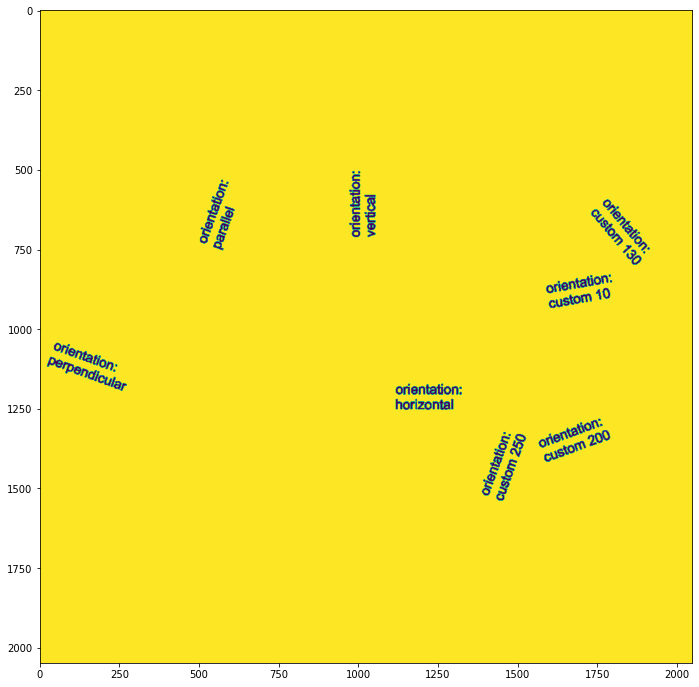

In [42]:
filename = f'testfiles/{filenames[img_idx]}'
img = cv2.imread(filename)
brightness = np.mean(img)
img = cv2.resize(img, (img.shape[1]*resize_factor, img.shape[0]*resize_factor))
# if brightness < 100:

# morph_kernel = np.ones((5,5))
# dilated = cv2.dilate(gray, kernel=morph_kernel)
# textmask = (dilated >= 0.15)
# enhanced = gray / dilated
# enhanced[~textmask] = gray[~textmask]
# output = 1- enhanced
# gray = output * 255

# else:
#     # threshold the image using Otsu's thresholding method
# gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,threshold_C)
if denoising:
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)
# img[:,:,2] = img[:,:,2] * 30
# img[:,:,1] = img[:,:,1] * 3
# img[:,:,2] = img[:,:,2] * 3
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# threshold_C = 4
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,threshold_C)
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

if brightness < 100:
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    lower_blue = np.array([110,50,50]) 
    upper_blue = np.array([130,255,255]) 

    # Here we are defining range of bluecolor in HSV 
    # This creates a mask of blue coloured  
    # objects found in the frame. 
    mask = cv2.inRange(hsv, lower_blue, upper_blue) 

    # The bitwise and of the frame and mask is done so  
    # that only the blue coloured objects are highlighted  
    # and stored in res 
    img = cv2.bitwise_and(img,img, mask= mask) 

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if thresholding:
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.figure(figsize=(20,12))
plt.imshow(img)

In [43]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy 

[[652.76776 609.78864]
 [637.21136 594.23224]
 [649.23224 582.21136]
 [664.78864 597.76776]]
[[904.8683  369.85965]
 [892.1404  357.13174]
 [921.1317  328.14035]
 [933.8596  340.86826]]
[[866.3536  439.2028 ]
 [850.7972  423.64645]
 [865.6464  408.7972 ]
 [881.2028  424.35355]]
[[929.0916  401.67822]
 [910.16364 374.64618]
 [924.9084  364.32178]
 [943.83636 391.35382]]
[[261.72372 345.59326]
 [251.22372 327.40674]
 [270.27628 316.40674]
 [280.77628 334.59326]]
[[797.9247  449.47723]
 [788.4247  433.02277]
 [810.0753  420.52277]
 [819.5753  436.97723]]
[[877.95184 456.83612]
 [869.92206 439.61627]
 [888.04816 431.16388]
 [896.07794 448.38373]]
[[788.57733 695.2113 ]
 [777.1667  670.74097]
 [871.42267 626.7887 ]
 [882.8333  651.25903]]
[[862.70135 686.21704]
 [854.6716  668.9972 ]
 [887.29865 653.78296]
 [895.3284  671.0028 ]]
[[489.35303 357.36246]
 [480.29437 323.55508]
 [498.64697 318.63754]
 [507.70563 352.44492]]
[[796.8777  453.0497 ]
 [790.666   429.86746]
 [891.1223  402.9503 ]
 

C:\Users\kajud\AppData\Local\Temp/ipykernel_16152/575951402.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


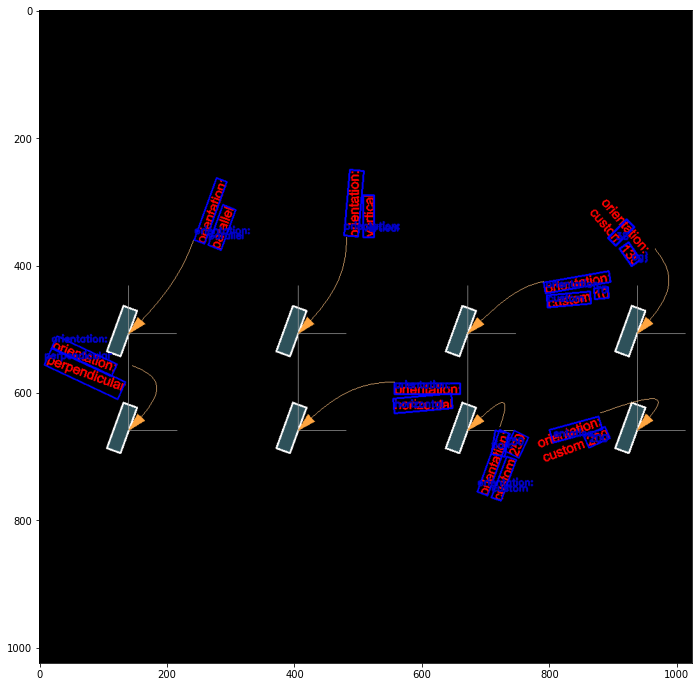

In [44]:
filename = f'testfiles/{filenames[img_idx]}'

img = cv2.imread(filename)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, img = cv2.threshold(img, 250, 255,cv2.THRESH_BINARY,cv2.THRESH_OTSU) #imgf contains Binary image
# plt.imshow(img)
height, width = img.shape[:2]
centerX, centerY = (width // 2, height // 2)

rrects = []
scores = []
texts = []
for angle in range(-45,45,5):               
    result = all_res[angle]

    for i in range(0, len(result["text"])):
        x = result["left"][i]
        y = result["top"][i]

        w = result["width"][i]
        h = result["height"][i]

        text = result["text"][i]
        conf = result["conf"][i]

        rect_center_x = (2*x+w)//2
        rect_center_y = (2*y+h)//2
        qx, qy = rotate((centerX, centerY),(rect_center_x, rect_center_y), math.radians(angle))
        rrect = ((int(qx),int(qy)), (w,h), angle)
        rrects.append(rrect)
        scores.append(conf)
        texts.append(text)

nms_res = nms.rboxes(rrects, scores, nms_algorithm=nms.felzenszwalb.nms)   
filtered_rrects = [rrects[i] for i in nms_res]
filtered_texts = [texts[i] for i in nms_res]
filtered_scores = [scores[i] for i in nms_res]
for rrect, text, conf in zip(filtered_rrects, filtered_texts, filtered_scores): 
    box = cv2.boxPoints(rrect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
    box = np.int0(box)
    cv2.drawContours(img,[box],0,(0,0,255),2)  
    # cv2.rectangle(img, (int(qx), int(qy)), (int(qx2), int(qy2)), (0, 255, 0), 2)
    # cv2.putText(img, text, (int(qx), int(qy) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)
    # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, text, (box[0][0], box[0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)
    print(text, conf)
        
plt.figure(figsize=(20,12))
plt.imshow(img)

# OpenCV + Tesseract

In [186]:
def correct_skew(image, delta=10, limit=360):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

C:\Users\kajud\AppData\Local\Temp/ipykernel_16000/2375065038.py:18: RuntimeWarning: invalid value encountered in divide
  enhanced = gray / dilated
C:\Users\kajud\AppData\Local\Temp/ipykernel_16000/2375065038.py:65: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


19.916406631469727
68.96248626708984
19.916406631469727
19.983104705810547
38.571250915527344
19.983104705810547
19.98310661315918
20.185802459716797
17.429861068725586
81.08507537841797
49.9697380065918
16.22019386291504
90.0


<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

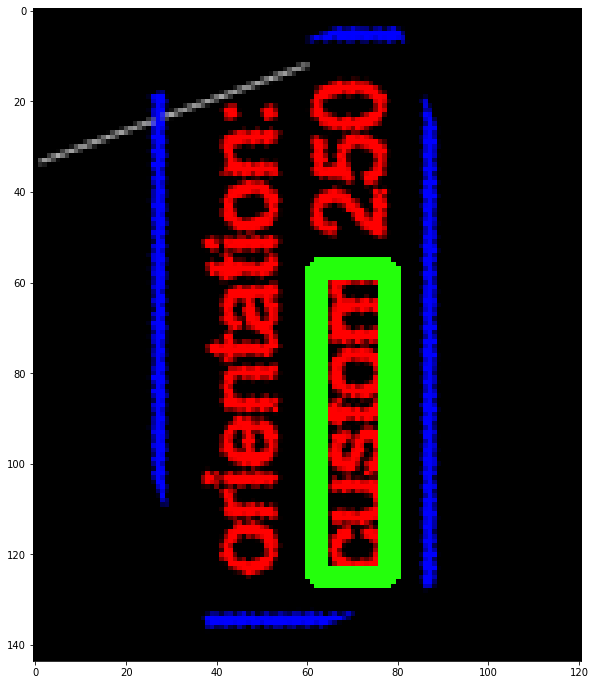

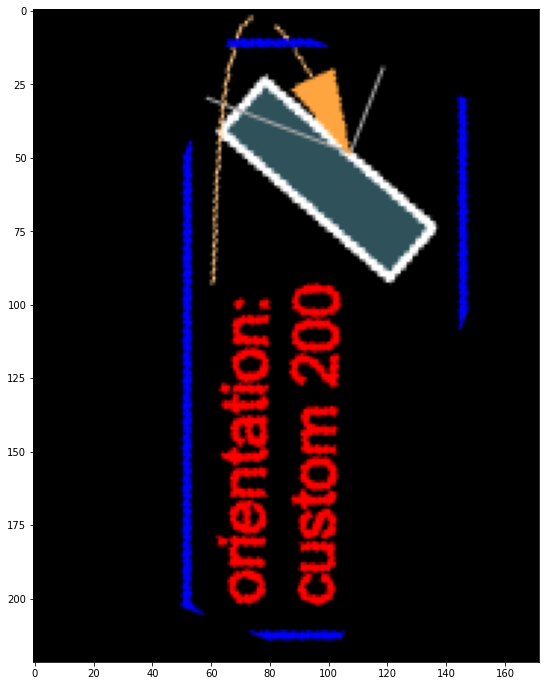

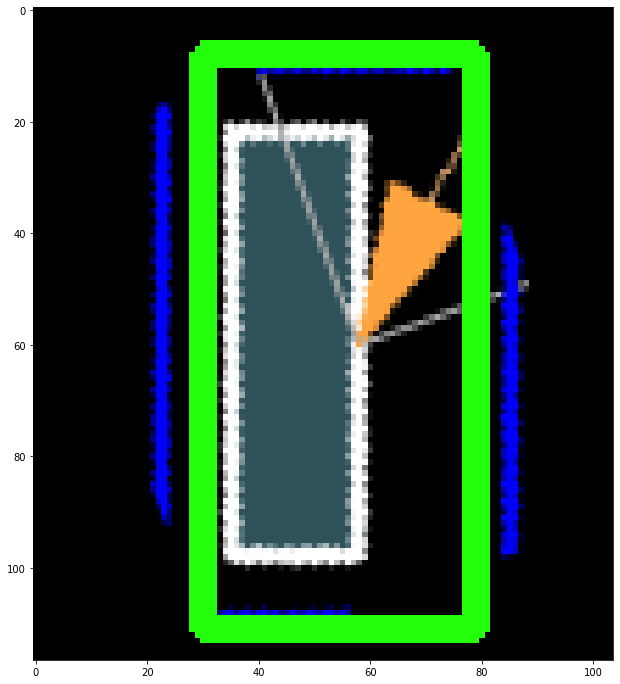

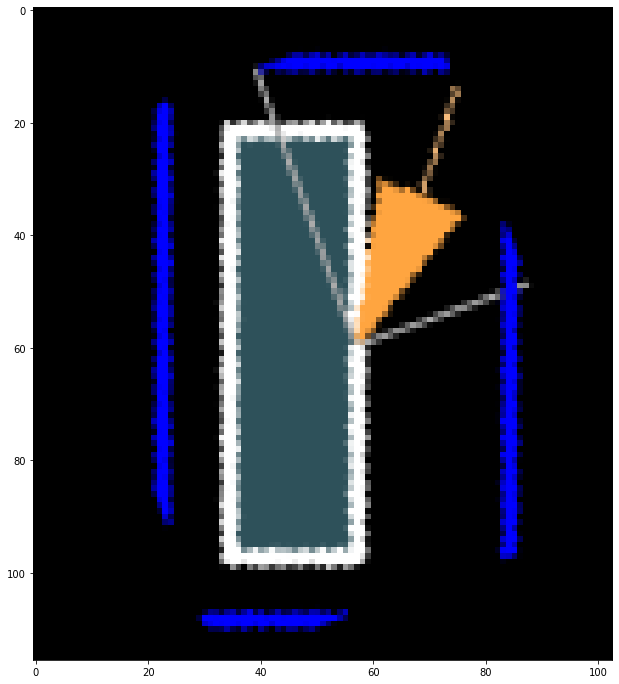

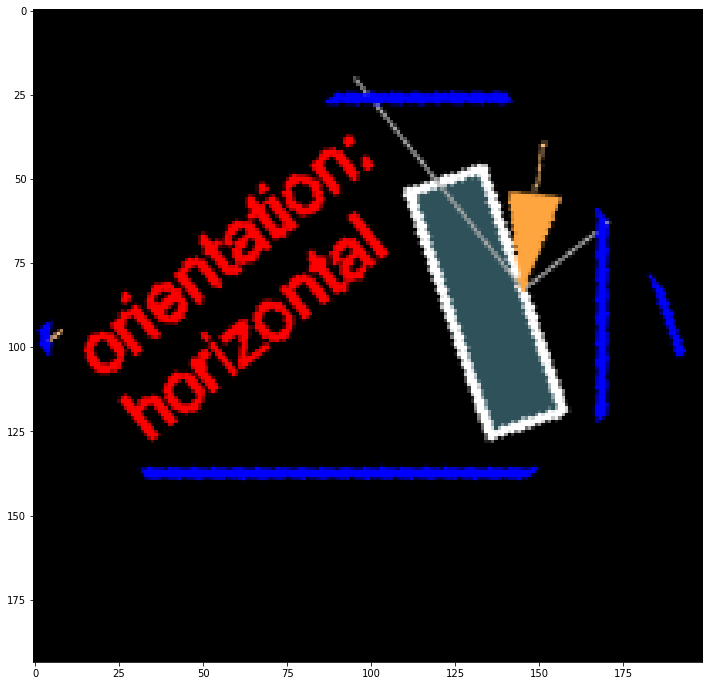

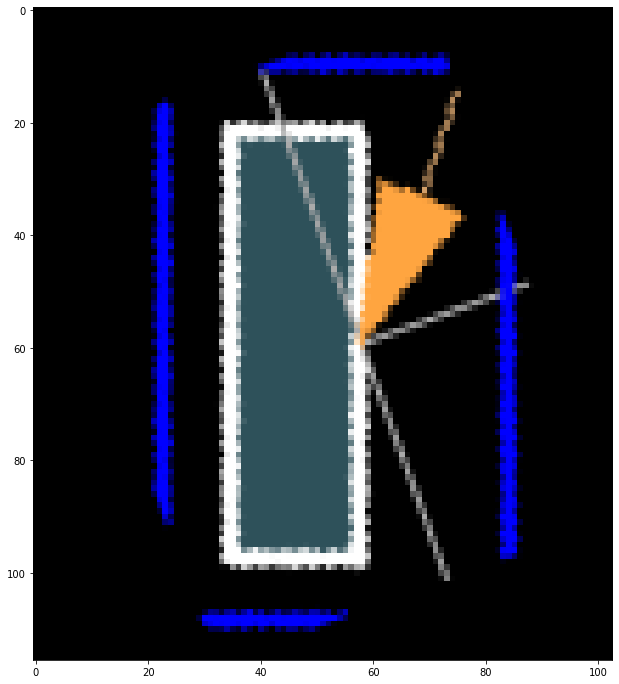

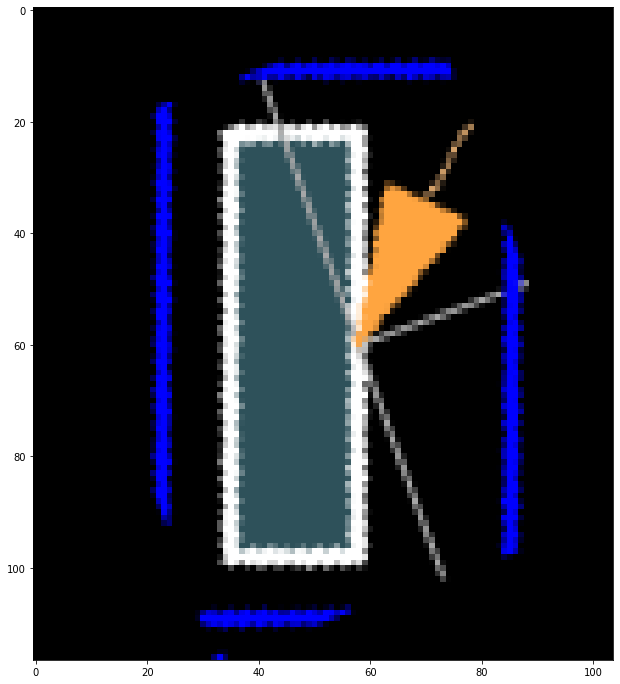

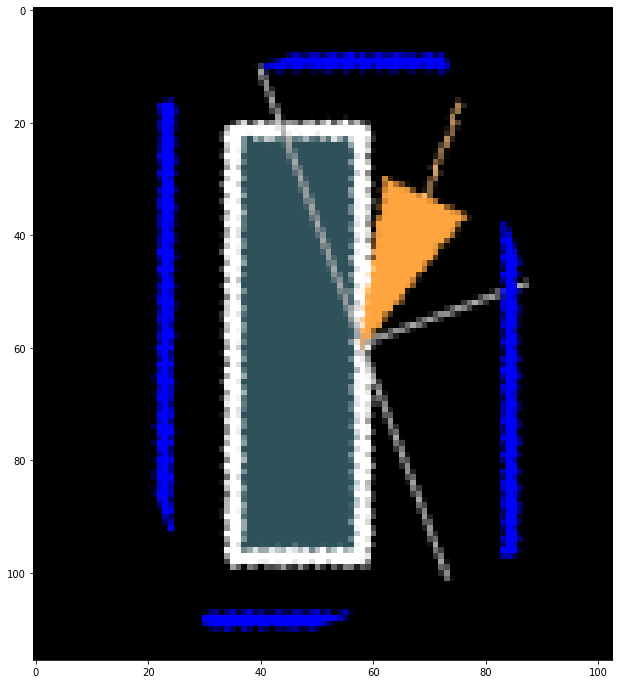

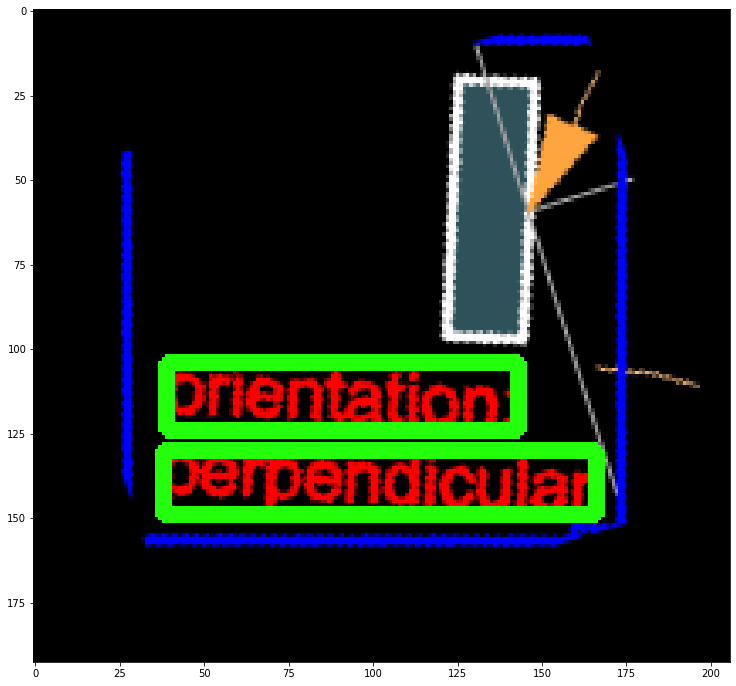

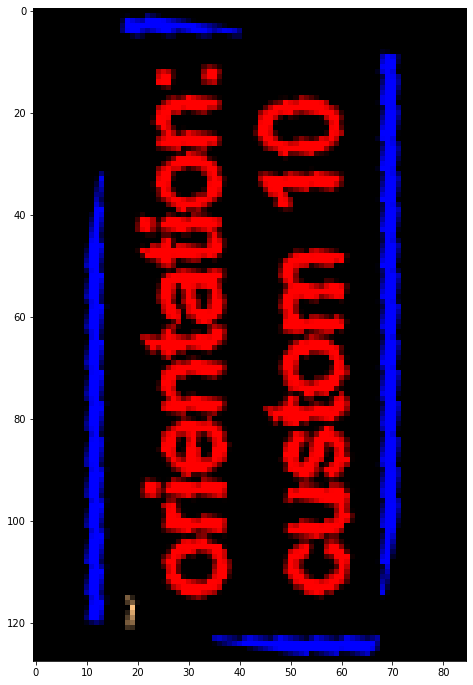

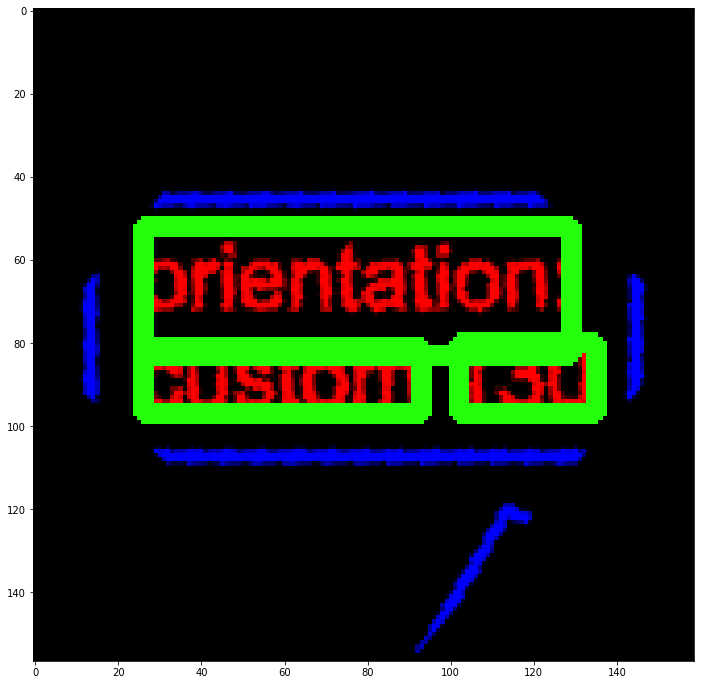

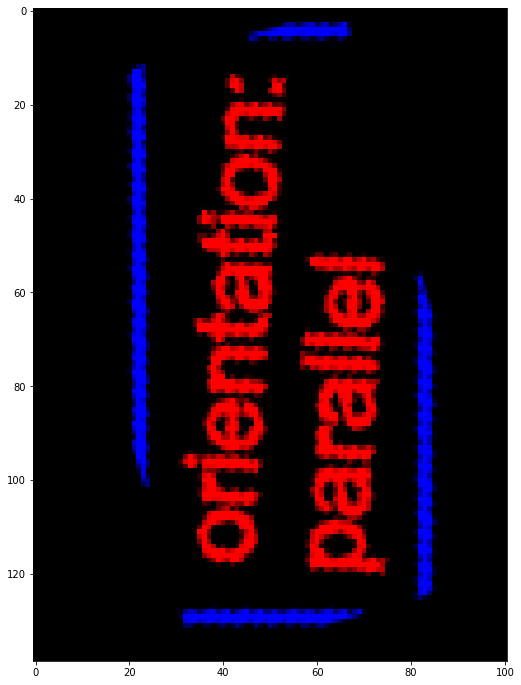

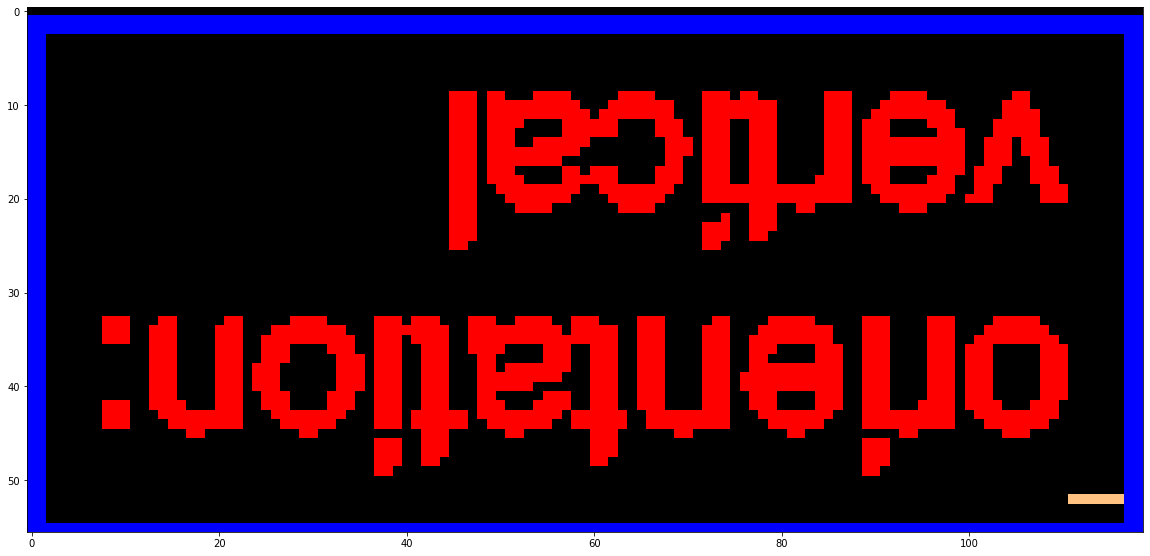

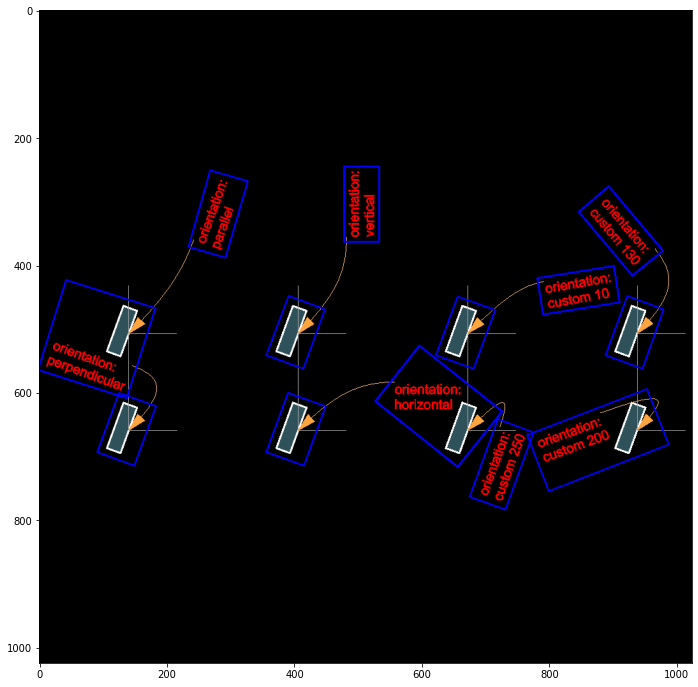

In [223]:
import cv2
plt.figure(figsize=(20,12))
# Load image, grayscale, Gaussian blur, adaptive threshold
# for i in range(0,10):
filename = f'testfiles/{filenames[-6]}'
image = cv2.imread(filename)
# image = cv2.bitwise_not(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

brightness = np.mean(gray)
threshold_C = 20

if brightness < 100:

    morph_kernel = np.ones((5,5))
    dilated = cv2.dilate(gray, kernel=morph_kernel)
    textmask = (dilated >= 0.15)
    enhanced = gray / dilated
    enhanced[~textmask] = gray[~textmask]
    output = 1- enhanced
    gray = output * 255

    threshold_C = 40
blur = cv2.GaussianBlur(gray.astype(np.uint8), (9,9), 0)
# plt.imshow(blur)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,threshold_C)

# results = pytesseract.image_to_data(image, output_type=Output.DICT)
# for i in range(0, len(results["text"])):
#     x = results["left"][i]
#     y = results["top"][i]

#     w = results["width"][i]
#     h = results["height"][i]

#     text = results["text"][i]
#     conf = int(results["conf"][i])

#     if conf > 70:
#         text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
#         if text != "" and len(text) > 1:
#             cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
#             cv2.putText(image, text, (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)

plt.figure(figsize=(20,12))
# plt.imshow(image)
# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=4)
plt.figure(figsize=(20,12))
# plt.imshow(dilate)
# Find contours, highlight text areas, and extract ROIs
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > 1000:
        x,y,w,h = cv2.boundingRect(c)
        minAreaRect = cv2.minAreaRect(c)
        angle = minAreaRect[-1]
        print(angle)
        box = cv2.boxPoints(minAreaRect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
        box = np.int0(box)
        cv2.drawContours(image,[box],0,(0,0,255),2)
        # cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
        ROI = copy.deepcopy(image[y:y+h, x:x+w])

        rotated = imutils.rotate_bound(ROI, angle=-angle)
    
        # cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        # ROI_number += 1
        # angle, ROI_corrected = correct_skew(ROI)
        # ROI = cv2.resize(ROI, (ROI.shape[0]*40, ROI.shape[1]*40))
        results = pytesseract.image_to_data(rotated, output_type=Output.DICT)
        # print(ROI.shape)
        
        # print(results_osd)
        for i in range(0, len(results["text"])):
            x = results["left"][i]
            y = results["top"][i]

            w = results["width"][i]
            h = results["height"][i]

            text = results["text"][i]
            conf = int(results["conf"][i])

            if conf > 70:
                text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
                if text != "" and len(text) > 1:
                    cv2.rectangle(rotated, (x, y), (x + w, y + h), (36,255,12), 3)
        
        plt.figure(figsize=(20,12))
        plt.imshow(rotated)

plt.figure(figsize=(20,12))
plt.imshow(image)

# MSER text detector

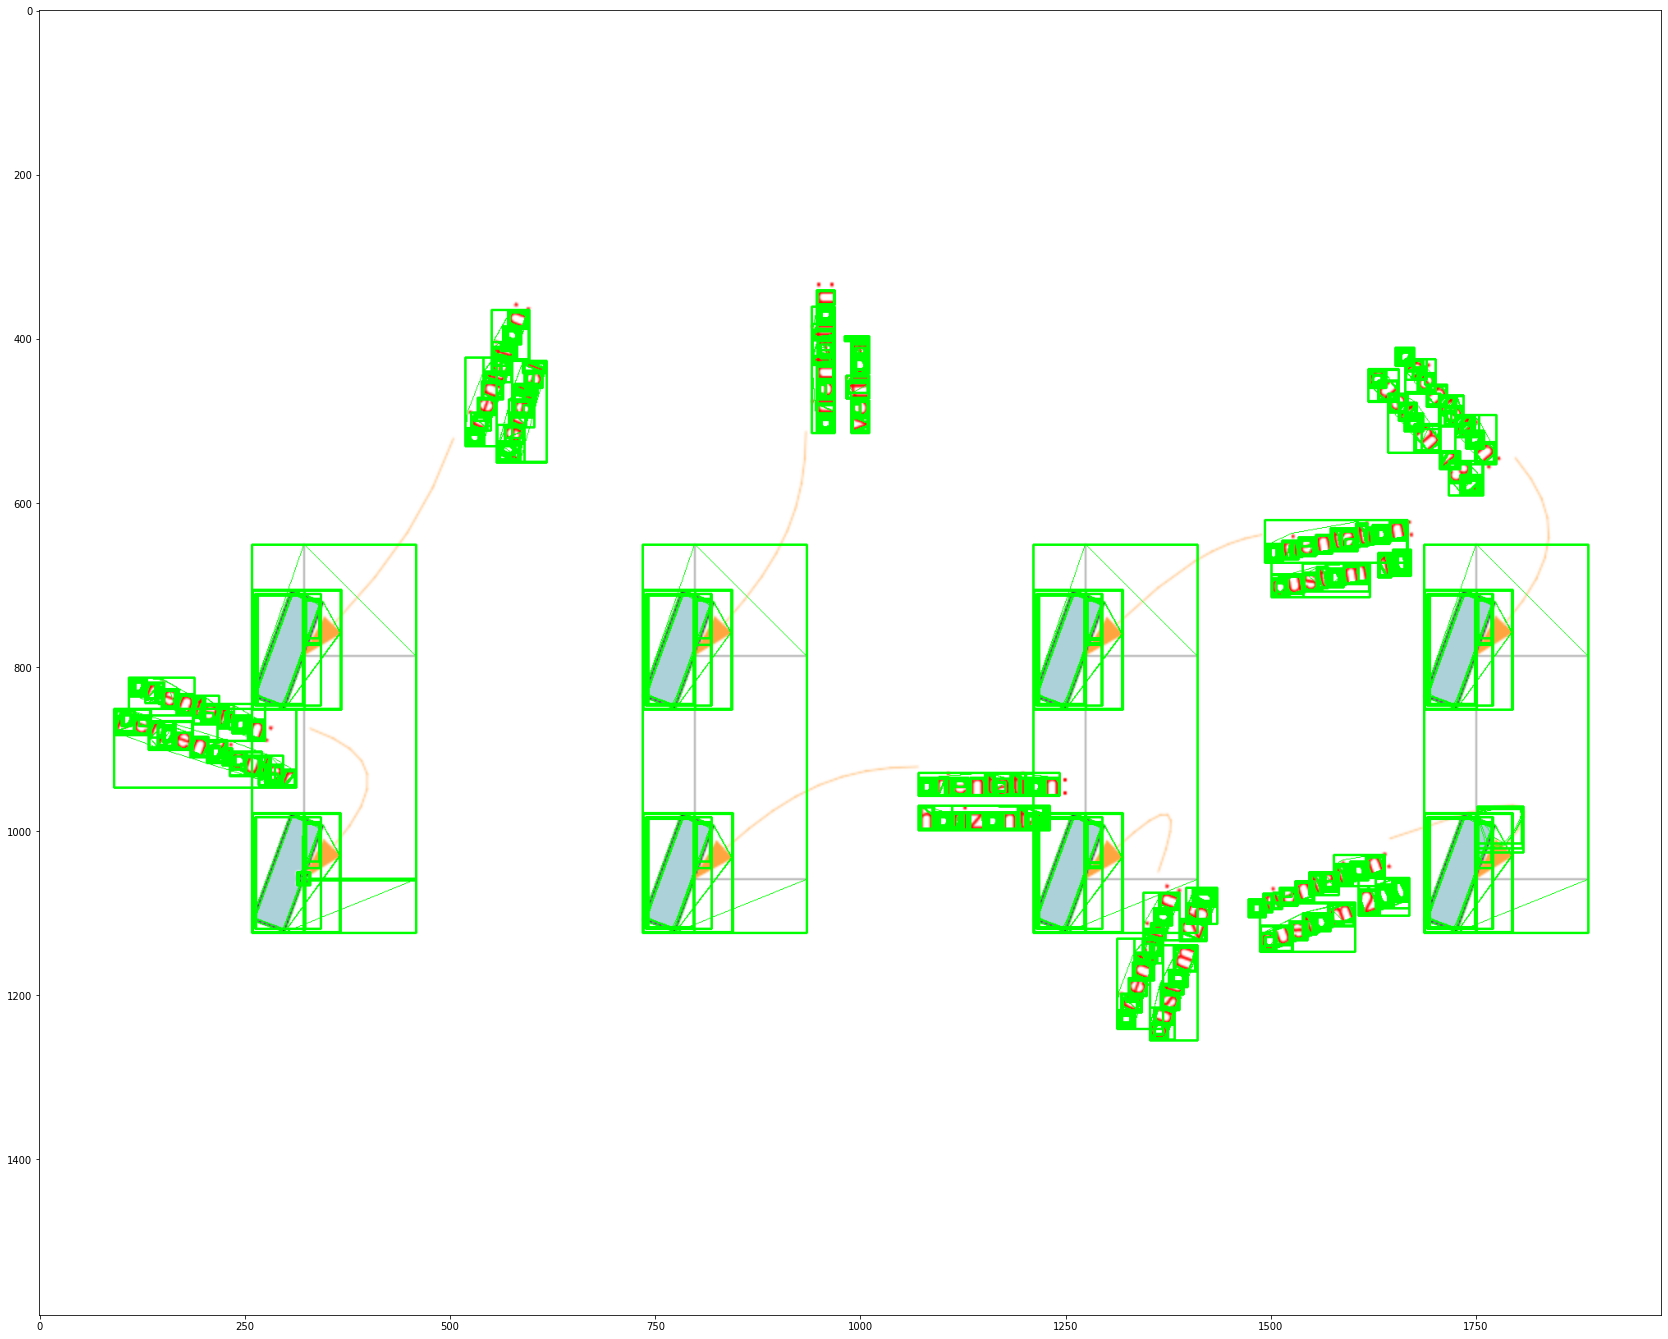

In [58]:
filename = f'testfiles/{filenames[-30]}'

img = cv2.imread(filename)
mser = cv2.MSER_create()

#Resize the image so that MSER can work better
img = cv2.resize(img, (img.shape[1]*2, img.shape[0]*2))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
vis = img.copy()

regions = mser.detectRegions(gray)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions[0]]
cv2.polylines(vis, hulls, 1, (0,255,0)) 
rects = []
for h in hulls:
    # rect = cv2.minAreaRect(h)
    # rects.append([rect[0][0], rect[0][1], rect[1][0], rect[1][1], rect[2]])
    # box = cv2.boxPoints(rect)
    # box = [[min()], 
    #        [], 
    #        [], 
    #        []]
    x,y,w,h = cv2.boundingRect(h)
    vis = cv2.rectangle(vis,(x,y),(x+w,y+h),(0,255,0),2)
    
# scores = [1.0]*len(rects)

# result = softnms_rotate_cpu(np.array(rects), scores, 0.1)

# box = np.int0(box)
# cv2.drawContours(vis, [box], 0, (0, 255, 0),1)

plt.figure(figsize=(40,24))
plt.imshow(vis)

# EAST Detector

In [57]:
import os, sys
import numpy as np
import cv2
import time
from imutils.object_detection import non_max_suppression

def east_detect(image):
    layerNames = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"]
    
    orig = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (1600, 1600)
    
    rW = W / float(newW)
    rH = H / float(newH)
    
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    
    (H, W) = image.shape[:2]
    
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    	(123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    start = time.time()
    
    net.setInput(blob)
    
    (scores, geometry) = net.forward(layerNames)
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
    
        for x in range(0, numCols):
    		# if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.7:
                continue
    		# compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
    	# scale the bounding box coordinates based on the respective
    	# ratios
    	startX = int(startX * rW)
    	startY = int(startY * rH)
    	endX = int(endX * rW)
    	endY = int(endY * rH)
    	# draw the bounding box on the image
    	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    
    print(time.time() - start)
    return orig

filename = f'testfiles/{filenames[-30]}'
image = cv2.imread(filename)

out_image = east_detect(image)

cv2.imwrite("sample_output.jpg", out_image)

2.8209919929504395


True